# Tutorial 1 - KERAS DNN Classification

We will predict the price category, among 4 categories, of an AIRBNB listing (`price_category` column). This is a multi-class classification task.

**The unit of analysis is an AIRBNB LISTING**

# Setup

In [1]:
# Common imports
import numpy as np
import pandas as pd

np.random.seed(42)


# Get the data

In [2]:
#We will predict the "price_gte_150" value in the data set:

airbnb = pd.read_csv("airbnb.csv")
airbnb.head()

,host_is_superhost,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,guests_included,price_per_extra_person,minimum_nights,number_of_reviews,number_days_btw_first_last_review,review_scores_rating,cancellation_policy,price,price_gte_150,price_category
0,0,0,Roslindale,42.282619,-71.133068,House,Entire home/apt,4,1.5,2.0,...,1,0,2,0,0,NaN,moderate,250,1,gte_226
1,0,1,Roslindale,42.286241,-71.134374,Apartment,Private room,2,1.0,1.0,...,0,0,2,36,804,94.0,moderate,65,0,lte_$75
2,1,1,Roslindale,42.292438,-71.135765,Apartment,Private room,2,1.0,1.0,...,1,20,3,41,2574,98.0,moderate,65,0,lte_$75
3,0,0,Roslindale,42.281106,-71.121021,House,Private room,4,1.0,1.0,...,2,25,1,1,0,100.0,moderate,75,0,lte_$75
4,1,1,Roslindale,42.284512,-71.136258,House,Private room,2,1.5,1.0,...,1,0,2,29,380,99.0,flexible,79,0,btw_$75-$150


# Split the data into train and test

In [3]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(airbnb, test_size=0.3)

### Be careful: we haven't seperated the target column yet

# Data Prep

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import FunctionTransformer

## Drop the variables we can't use in this tutorial

In [5]:
# We can't use the following columns in this tutorial

train = train_set.drop(['price', 'price_gte_150'], axis=1)
test = test_set.drop(['price', 'price_gte_150'], axis=1)

## Separate the target variable (we don't want to transform it)

In [6]:
train_target = train[['price_category']]
test_target = test[['price_category']]

train_inputs = train.drop(['price_category'], axis=1)
test_inputs = test.drop(['price_category'], axis=1)

## Feature Engineering: Let's derive a new column

#### Remember, the "minimum_nights" column is highly skewed. Let's try to transform it. 

In [7]:
train_inputs['minimum_nights'].value_counts()

1      1017
2       666
3       443
4        88
7        82
5        58
10       45
30       18
14       16
15       14
6        12
28        6
20        5
32        3
60        3
9         2
18        1
13        1
8         1
273       1
11        1
21        1
90        1
23        1
17        1
25        1
Name: minimum_nights, dtype: int64

<Axes: >

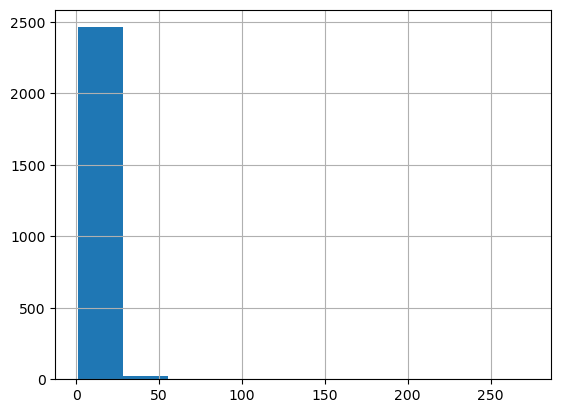

In [8]:
train_inputs['minimum_nights'].hist()

In [9]:
# Import power transformer from sklearn. It will help us create a "normal distribution"
from sklearn.preprocessing import PowerTransformer

PT = PowerTransformer(method = 'yeo-johnson', standardize=True)

In [10]:
transformed_min_nights = PT.fit_transform(train_inputs[['minimum_nights']])

array([[<Axes: title={'center': '0'}>]], dtype=object)

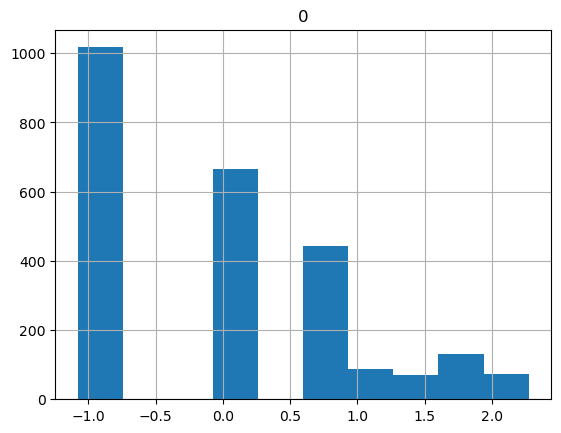

In [11]:
pd.DataFrame(transformed_min_nights).hist()

NOTE1: We didn't make the transformed variable as part of the input variables yet. To do that, we will use the pipeline.

NOTE2: We don't need to create a function (like before). This transformer already has fit() and transform(). So, we can use this in the pipeline.

##  Identify the numerical and categorical columns

In [12]:
train_inputs.dtypes

host_is_superhost                      int64
host_identity_verified                 int64
neighbourhood_cleansed                object
latitude                             float64
longitude                            float64
property_type                         object
room_type                             object
accommodates                           int64
bathrooms                            float64
bedrooms                             float64
beds                                 float64
bed_type                              object
Number of amenities                    int64
guests_included                        int64
price_per_extra_person                 int64
minimum_nights                         int64
number_of_reviews                      int64
number_days_btw_first_last_review      int64
review_scores_rating                 float64
cancellation_policy                   object
dtype: object

**At this stage, you can manually identify numeric, binary, and categorical columns as follows:**

`numeric_columns = ['latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'Number of amenities', 'guests_included', 'price_per_extra_person', 'minimum_nights', 'number_of_reviews', 'number_days_btw_first_last_review', 'review_scores_rating']`
 
 `binary_columns = ['host_is_superhost', 'host_identity_verified']`
 
 `categorical_columns = ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type', 'cancellation_policy']`
 
<br>
 
**If you do not want to manually type these, you can do the below tricks:**

In [13]:
# Identify the numerical columns
numeric_columns = train_inputs.select_dtypes(include=[np.number]).columns.to_list()

# Identify the categorical columns
categorical_columns = train_inputs.select_dtypes('object').columns.to_list()

In [14]:
# Identify the binary columns so we can pass them through without transforming
binary_columns = ['host_is_superhost', 'host_identity_verified']

In [15]:
# Be careful: numerical columns already includes the binary columns,
# So, we need to remove the binary columns from numerical columns.

for col in binary_columns:
    numeric_columns.remove(col)

In [16]:
binary_columns

['host_is_superhost', 'host_identity_verified']

In [17]:
numeric_columns

['latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'Number of amenities',
 'guests_included',
 'price_per_extra_person',
 'minimum_nights',
 'number_of_reviews',
 'number_days_btw_first_last_review',
 'review_scores_rating']

In [18]:
categorical_columns

['neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type',
 'cancellation_policy']

In [19]:
transformed_columns = ['minimum_nights']

# Pipeline

In [20]:
numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [21]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [22]:
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

In [23]:
my_new_column = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('powertransformer', PowerTransformer(method = 'yeo-johnson', standardize=True))])

In [24]:
preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('binary', binary_transformer, binary_columns),
        ('trans', my_new_column, transformed_columns)],
        remainder='passthrough')

#passtrough is an optional step. You don't have to use it.

# Transform: fit_transform() for TRAIN

In [25]:
#Fit and transform the train data
train_x = preprocessor.fit_transform(train_inputs)

train_x

array([[ 0.82254842,  0.69215829,  0.54753414, ...,  1.        ,
         1.        ,  0.22348218],
       [ 0.55146572,  0.15729058,  0.54753414, ...,  0.        ,
         1.        ,  0.22348218],
       [ 0.07311286, -1.97951247, -0.59100739, ...,  0.        ,
         0.        ,  1.39051005],
       ...,
       [-0.61093878, -0.07631528,  3.96315871, ...,  0.        ,
         1.        , -1.07759248],
       [ 1.17819153, -0.94575177, -1.16027815, ...,  0.        ,
         0.        , -1.07759248],
       [-0.33618088,  1.03587419, -0.59100739, ...,  0.        ,
         1.        ,  0.22348218]])

In [26]:
train_x.shape

(2488, 67)

# Tranform: transform() for TEST

In [27]:
# Transform the test data
test_x = preprocessor.transform(test_inputs)

test_x

array([[-1.21269719, -1.20324989,  0.54753414, ...,  0.        ,
         1.        ,  0.22348218],
       [-2.86419979, -2.67831359, -0.59100739, ...,  0.        ,
         0.        , -1.07759248],
       [-0.11443035,  1.26295963, -0.59100739, ...,  0.        ,
         1.        , -1.07759248],
       ...,
       [ 0.47803436, -1.63486781, -0.59100739, ...,  1.        ,
         1.        , -1.07759248],
       [ 0.59928397,  0.34795157,  2.82461719, ...,  0.        ,
         0.        ,  0.22348218],
       [ 0.19953968,  0.22845713, -0.59100739, ...,  0.        ,
         1.        ,  1.65188006]])

In [28]:
test_x.shape

(1067, 67)

# Keras needs Ordinal target values for classification

In [29]:
train_target

,price_category
1965,gte_226
1450,btw_$151-$225
2503,lte_$75
944,lte_$75
199,btw_$75-$150
...,...
1130,btw_$75-$150
1294,gte_226
860,gte_226
3507,btw_$75-$150


In [30]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()

train_y = ord_enc.fit_transform(train_target)

train_y

array([[2.],
       [0.],
       [3.],
       ...,
       [2.],
       [1.],
       [1.]])

In [31]:
test_y = ord_enc.transform(test_target)

test_y

array([[1.],
       [1.],
       [2.],
       ...,
       [1.],
       [2.],
       [1.]])

# Baseline

In [32]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_clf.fit(train_x, train_y)

DummyClassifier(strategy='most_frequent')

In [33]:
from sklearn.metrics import accuracy_score

In [34]:
#Baseline Train Accuracy
dummy_train_pred = dummy_clf.predict(train_x)

baseline_train_acc = accuracy_score(train_y, dummy_train_pred)

print('Baseline Train Accuracy: {}' .format(baseline_train_acc))

Baseline Train Accuracy: 0.3311897106109325


In [35]:
#Baseline Test Accuracy
dummy_test_pred = dummy_clf.predict(test_x)

baseline_test_acc = accuracy_score(test_y, dummy_test_pred)

print('Baseline Test Accuracy: {}' .format(baseline_test_acc))

Baseline Test Accuracy: 0.3402061855670103


# Multiclass classification using Keras



In [36]:
import tensorflow as tf
from tensorflow import keras

# fix random seed for reproducibility
# random seed do not work, so below dont work
np.random.seed(42)
tf.random.set_seed(42)

In [37]:
#What is your input shape?
#(meaning: how many neurons should be in the input layer?)

train_x.shape

(2488, 67)

In [50]:
train_x.shape[1]

67

## Single Layer (Shallow) Network

In [42]:
#Define the model: for multi-class

model = keras.models.Sequential()

model.add(keras.layers.Input(shape=(67,))) # match the columns # train_x.shape[1] see above cell replace instead of 67
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(4, activation='softmax')) # as it is multiclass and 4 target nuerons, as there are 4 categories

#final layer: there has to be 4 nodes with softmax (because we have 4 categories)


In [43]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │         3,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,604 (14.08 KB)

 Trainable params: 3,604 (14.08 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Compile model

#Optimizer:
adam = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

## Ordinal target (as in this example):

Final layer's activation = **softmax** <br>
loss = **sparse_categorical_crossentropy**

## Binary target 

Final layer has only 1 neuron <br>
Final layer's activation = **sigmoid** <br>
loss = **binary_crossentropy**

## One-hot target (rare cases)

Final layer's activation = **softmax** <br>
loss = **categorical_crossentropy**

## Regression task (target is continuous)

Final layer has only 1 neuron (keras.layers.Dense(1))<br>
Activation is None<br>
loss = **mean_squared_error**


In [45]:
# Fit the model

history = model.fit(train_x, train_y, 
                    validation_data=(test_x, test_y), 
                    epochs=20, batch_size=100)# 2500 rows will split into 100

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.4180 - loss: 1.2190 - val_accuracy: 0.5989 - val_loss: 0.8709
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5952 - loss: 0.8937 - val_accuracy: 0.6270 - val_loss: 0.8187
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6302 - loss: 0.8274 - val_accuracy: 0.6401 - val_loss: 0.8028
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6527 - loss: 0.7909 - val_accuracy: 0.6382 - val_loss: 0.7983
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6657 - loss: 0.7615 - val_accuracy: 0.6495 - val_loss: 0.7965
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6789 - loss: 0.7315 - val_accuracy: 0.6495 - val_loss: 0.8008
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6920 - loss: 0.7051 - val_accuracy: 0.6467 - val_loss: 0.8044
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7081 - loss: 0.6770 - val_accuracy: 0.6467 - val_loss

In [46]:
# Train values

train_scores = model.evaluate(train_x, train_y, verbose=0)

train_scores

# In results, first is loss, second is accuracy

[0.4375588893890381, 0.8291800618171692]

In [47]:
# Print the values
# the loss it does not have any meaning

print(f"Train {model.metrics_names[0]}: {train_scores[0]:.2f}")

print(f"Train {model.metrics_names[1]}: {train_scores[1]*100:.2f}%")


Train loss: 0.44
Train compile_metrics: 82.92%


In [48]:
# Test values

test_scores = model.evaluate(test_x, test_y, verbose=0)

test_scores

# In results, first is loss, second is accuracy

[1.0292726755142212, 0.6307404041290283]

In [49]:
# Print the values
# the loss it does not have any meaning

print(f"Test {model.metrics_names[0]}: {test_scores[0]:.2f}")

print(f"Test {model.metrics_names[1]}: {test_scores[1]*100:.2f}%")


Test loss: 1.03
Test compile_metrics: 63.07%


## have to apply regularization as the above is overfitting

## Deep Network (Pipe Architecture)

In [53]:
#Define the model: for multi-class
# Pipe archietecture
model = keras.models.Sequential()

model.add(keras.layers.Input(shape=(67,)))
model.add(keras.layers.Dense(67, activation='relu'))
model.add(keras.layers.Dense(67, activation='relu'))
model.add(keras.layers.Dense(67, activation='relu'))
model.add(keras.layers.Dense(4, activation='softmax'))

#final layer: there has to be 4 nodes with softmax (because we have 4 categories)

In [54]:
# Compile model

#Optimizer:
adam = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [55]:
# Fit the model

history = model.fit(train_x, train_y, 
                    validation_data=(test_x, test_y), 
                    epochs=20, batch_size=100)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.4260 - loss: 1.1754 - val_accuracy: 0.6129 - val_loss: 0.8601
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5651 - loss: 0.9054 - val_accuracy: 0.6120 - val_loss: 0.8582
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5961 - loss: 0.8576 - val_accuracy: 0.6204 - val_loss: 0.8364
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6314 - loss: 0.8051 - val_accuracy: 0.6317 - val_loss: 0.8278
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6723 - loss: 0.7458 - val_accuracy: 0.6457 - val_loss: 0.8279
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6867 - loss: 0.6893 - val_accuracy: 0.6429 - val_loss: 0.8674
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7150 - loss: 0.6468 - val_accuracy: 0.6336 - val_loss: 0.9471
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7389 - loss: 0.5990 - val_accuracy: 0.6120 - val_los

In [56]:
# Train values

train_scores = model.evaluate(train_x, train_y, verbose=0)

train_scores

# In results, first is loss, second is accuracy

[0.29174214601516724, 0.875]

In [57]:
# Print the values

print(f"Train {model.metrics_names[0]}: {train_scores[0]:.2f}")

print(f"Train {model.metrics_names[1]}: {train_scores[1]*100:.2f}%")


Train loss: 0.29
Train compile_metrics: 87.50%


In [58]:
# Test values

test_scores = model.evaluate(test_x, test_y, verbose=0)

test_scores

# In results, first is loss, second is accuracy

[1.4540643692016602, 0.6101218461990356]

In [59]:
# Print the values

print(f"Test {model.metrics_names[0]}: {test_scores[0]:.2f}")

print(f"Test {model.metrics_names[1]}: {test_scores[1]*100:.2f}%")


Test loss: 1.45
Test compile_metrics: 61.01%


In [ ]:
## Additional layers above made it worse as it made model overfit model

# Wide & Deep Network

## Let's send all inputs to the last layer

In [61]:
model = keras.models.Sequential()


inputlayer = keras.layers.Input(shape=(67,))

hidden1 = keras.layers.Dense(67, activation='relu')(inputlayer)
hidden2 = keras.layers.Dense(67, activation='relu')(hidden1)
hidden3 = keras.layers.Dense(67, activation='relu')(hidden2)

concat = keras.layers.Concatenate()([inputlayer, hidden3]) # Concatenate with input above that is stack this layer has 134 neurons
# logic is taking advantage of nueral network and another model say regression, where you can advanatage of learnings of linear and non linear

#final layer: there has to be 4 nodes with softmax (because we have 4 categories)
output = keras.layers.Dense(4, activation='softmax')(concat)

model = keras.Model(inputs =[inputlayer], outputs = output)


In [63]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 67)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 67)        │      4,556 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 67)        │      4,556 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 67)        │      4,556 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 134)       │          0 │ input_layer_7[0]… │
│ (Concatenate)       │                   │            │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 4)         │        540 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,208 (55.50 KB)

 Trainable params: 14,208 (55.50 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# Compile model

#Optimizer:
adam = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [65]:
# Fit the model

history = model.fit(train_x, train_y, 
                    validation_data=(test_x, test_y), 
                    epochs=20, batch_size=100)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.4533 - loss: 1.1550 - val_accuracy: 0.5951 - val_loss: 0.8630
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5762 - loss: 0.8901 - val_accuracy: 0.6214 - val_loss: 0.8271
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6269 - loss: 0.8062 - val_accuracy: 0.6214 - val_loss: 0.8156
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6631 - loss: 0.7498 - val_accuracy: 0.6373 - val_loss: 0.8287
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6816 - loss: 0.7003 - val_accuracy: 0.6232 - val_loss: 0.8650
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6995 - loss: 0.6535 - val_accuracy: 0.6270 - val_loss: 0.9384
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7061 - loss: 0.6302 - val_accuracy: 0.6364 - val_loss: 0.9826
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7449 - loss: 0.5808 - val_accuracy: 0.6429 - val_loss

In [66]:
# Train values

train_scores = model.evaluate(train_x, train_y, verbose=0)

train_scores

# In results, first is loss, second is accuracy

[0.26955220103263855, 0.895900309085846]

In [67]:
# Print the values

print(f"Train {model.metrics_names[0]}: {train_scores[0]:.2f}")

print(f"Train {model.metrics_names[1]}: {train_scores[1]*100:.2f}%")


Train loss: 0.27
Train compile_metrics: 89.59%


In [68]:
# Test values

test_scores = model.evaluate(test_x, test_y, verbose=0)

test_scores

# In results, first is loss, second is accuracy

[1.753150224685669, 0.6138706803321838]

In [69]:
# Print the values

print(f"Test {model.metrics_names[0]}: {test_scores[0]:.2f}")

print(f"Test {model.metrics_names[1]}: {test_scores[1]*100:.2f}%")


Test loss: 1.75
Test compile_metrics: 61.39%


## Let's send two inputs to the last layer

In [70]:
# Select the first two columns: longitude and latitude
#(WHY: because lat and lon are good and important predictors)

train_lon_lat = train_x[:,:2] # take only 2 out of 67 ---> The two rows are lat, longi together gives location

# there fore we only to hidden layer 3 so as to find target as location

train_lon_lat

array([[ 0.82254842,  0.69215829],
       [ 0.55146572,  0.15729058],
       [ 0.07311286, -1.97951247],
       ...,
       [-0.61093878, -0.07631528],
       [ 1.17819153, -0.94575177],
       [-0.33618088,  1.03587419]])

In [71]:
test_lon_lat = test_x[:,:2]

In [74]:
model = keras.models.Sequential()

input1 = keras.layers.Input(shape=(2,))
input2 = keras.layers.Input(shape=(67,))

hidden1 = keras.layers.Dense(67, activation='relu')(input2)
hidden2 = keras.layers.Dense(67, activation='relu')(hidden1)
hidden3 = keras.layers.Dense(67, activation='relu')(hidden2)

concat = keras.layers.Concatenate()([input1, hidden3])

#final layer: there has to be 4 nodes with softmax (because we have 4 categories)
output = keras.layers.Dense(4, activation='softmax')(concat)

model = keras.Model(inputs =[input1, input2], outputs = output)

In [75]:
# Compile model

#Optimizer:
adam = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [76]:
# Fit the model

history = model.fit((train_lon_lat, train_x), train_y, 
                    validation_data=((test_lon_lat, test_x), test_y), 
                    epochs=20, batch_size=100)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.4684 - loss: 1.1340 - val_accuracy: 0.5829 - val_loss: 0.8690
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5699 - loss: 0.9028 - val_accuracy: 0.6420 - val_loss: 0.8151
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6060 - loss: 0.8383 - val_accuracy: 0.6223 - val_loss: 0.8273
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6425 - loss: 0.7928 - val_accuracy: 0.6092 - val_loss: 0.8597
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6535 - loss: 0.7640 - val_accuracy: 0.6214 - val_loss: 0.8973
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6717 - loss: 0.7299 - val_accuracy: 0.6270 - val_loss: 0.8641
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7176 - loss: 0.6618 - val_accuracy: 0.6364 - val_loss: 0.9032
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7398 - loss: 0.5958 - val_accuracy: 0.6298 - val_loss

In [77]:
# Train values

train_scores = model.evaluate((train_lon_lat, train_x), train_y, verbose=0)

train_scores

# In results, first is loss, second is accuracy

[0.25551721453666687, 0.903938889503479]

In [78]:
# Print the values

print(f"Train {model.metrics_names[0]}: {train_scores[0]:.2f}")

print(f"Train {model.metrics_names[1]}: {train_scores[1]*100:.2f}%")


Train loss: 0.26
Train compile_metrics: 90.39%


In [79]:
# Test values

test_scores = model.evaluate((test_lon_lat, test_x), test_y, verbose=0)

test_scores

# In results, first is loss, second is accuracy

[1.7355337142944336, 0.5885660648345947]

In [80]:
# Print the values

print(f"Test {model.metrics_names[0]}: {test_scores[0]:.2f}")

print(f"Test {model.metrics_names[1]}: {test_scores[1]*100:.2f}%")


Test loss: 1.74
Test compile_metrics: 58.86%


# Optimizers, Learning rate, Dropout, Initialization & Activation functions

In [82]:
#Define the model: for multi-class


#Set the learning rate:
lr=0.01


#Available optimizers:
adafactor = keras.optimizers.Adafactor(learning_rate=lr)
adam = keras.optimizers.Adam(learning_rate=lr)
adamw = keras.optimizers.AdamW(learning_rate=lr)
lion = keras.optimizers.Lion(learning_rate=lr)

#Initializations:
xavier = keras.initializers.GlorotNormal(seed=123)
he = keras.initializers.HeNormal(seed=234)
lecun = keras.initializers.LecunNormal(seed=345)


# Activation functions. Uncomment only one
elu = 'elu' 
relu = 'relu'
tanh = 'tanh'
sigmoid = 'sigmoid'
selu = 'selu'
gelu = 'gelu'



#See the droput layers below:
input1 = keras.layers.Input(shape=(67,))

hidden1 = keras.layers.Dense(67, activation=elu, kernel_initializer=xavier)(input1)
drop1   = keras.layers.Dropout(0.2)(hidden1)
hidden2 = keras.layers.Dense(67, activation=relu, kernel_initializer=he)(drop1)
drop2   = keras.layers.Dropout(0.2)(hidden2)
hidden3 = keras.layers.Dense(67, activation=gelu, kernel_initializer=lecun)(drop2)

#final layer: there has to be 4 nodes with softmax (because we have 4 categories)
output = keras.layers.Dense(4, activation='softmax')(hidden3)

#Compile"
model = keras.Model(inputs = input1, outputs = output)

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=adam, metrics=['accuracy'])

In [83]:
# Fit the model

history = model.fit(train_x, train_y, 
                    validation_data=(test_x, test_y), 
                    epochs=20, batch_size=100)



Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.4353 - loss: 1.1902 - val_accuracy: 0.6017 - val_loss: 0.8650
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5427 - loss: 0.9666 - val_accuracy: 0.6186 - val_loss: 0.8397
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5780 - loss: 0.9172 - val_accuracy: 0.6186 - val_loss: 0.8327
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6045 - loss: 0.8756 - val_accuracy: 0.6270 - val_loss: 0.8163
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6090 - loss: 0.8567 - val_accuracy: 0.6382 - val_loss: 0.8082
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6096 - loss: 0.8328 - val_accuracy: 0.6382 - val_loss: 0.8170
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6140 - loss: 0.8310 - val_accuracy: 0.6354 - val_loss: 0.8087
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6234 - loss: 0.8013 - val_accuracy: 0.6223 - val_l

In [84]:
# Train values

train_scores = model.evaluate(train_x, train_y, verbose=0)

train_scores

# In results, first is loss, second is accuracy

[0.5812166929244995, 0.75]

In [85]:
# Print the values

print(f"Train {model.metrics_names[0]}: {train_scores[0]:.2f}")

print(f"Train {model.metrics_names[1]}: {train_scores[1]*100:.2f}%")


Train loss: 0.58
Train compile_metrics: 75.00%


In [86]:
# Test values

test_scores = model.evaluate(test_x, test_y, verbose=0)

test_scores

# In results, first is loss, second is accuracy

[0.852786123752594, 0.6091846227645874]

In [87]:
# Print the values

print(f"Test {model.metrics_names[0]}: {test_scores[0]:.2f}")

print(f"Test {model.metrics_names[1]}: {test_scores[1]*100:.2f}%")


Test loss: 0.85
Test compile_metrics: 60.92%


# Early stopping based on validation results

To do this, you need to send the validation data sets to the fit() function and use a callback.

EarlyStopping Arguments:

**monitor:** quantity to be monitored.<br>
**min_delta:** minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.<br>
**patience:** number of epochs with no improvement after which training will be stopped.<br>
**verbose:** verbosity mode.<br>
**mode:** one of {auto, min, max}. In min mode, training will stop when the quantity monitored has stopped decreasing; in max mode it will stop when the quantity monitored has stopped increasing; in auto mode, the direction is automatically inferred from the name of the monitored quantity.<br>
**baseline:** Baseline value for the monitored quantity to reach. Training will stop if the model doesn't show improvement over the baseline.<br>
**restore_best_weights:** whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.

In [92]:
#Define the model: for multi-class

model = keras.models.Sequential()

model.add(keras.layers.Input(shape=(67,)))
model.add(keras.layers.Dense(67, activation='relu'))
model.add(keras.layers.Dense(67, activation='relu'))
model.add(keras.layers.Dense(67, activation='relu'))
model.add(keras.layers.Dense(4, activation='softmax'))

#final layer: there has to be 4 nodes with softmax (because we have 4 categories)

In [93]:
adam = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=adam, metrics=['accuracy'])

In [94]:
from tensorflow.keras.callbacks import EarlyStopping


earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

callback = [earlystop]

model.fit(train_x, train_y, validation_data=(test_x, test_y), 
          epochs=100, batch_size=100, callbacks=callback)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.3788 - loss: 1.3106 - val_accuracy: 0.5267 - val_loss: 1.0840
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5269 - loss: 1.0536 - val_accuracy: 0.6064 - val_loss: 0.9075
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5691 - loss: 0.9418 - val_accuracy: 0.6270 - val_loss: 0.8601
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6069 - loss: 0.8874 - val_accuracy: 0.6392 - val_loss: 0.8330
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6271 - loss: 0.8464 - val_accuracy: 0.6495 - val_loss: 0.8140
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6445 - loss: 0.8145 - val_accuracy: 0.6495 - val_loss: 0.8024
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6619 - loss: 0.7883 - val_accuracy: 0.6598 - val_loss: 0.7944
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6709 - loss: 0.7660 - val_accuracy: 0.6654 - 

In [95]:
# Train values

train_scores = model.evaluate(train_x, train_y, verbose=0)

train_scores

# In results, first is loss, second is accuracy

[0.5758649110794067, 0.7656752467155457]

In [96]:
# Print the values

print(f"Train {model.metrics_names[0]}: {train_scores[0]:.2f}")

print(f"Train {model.metrics_names[1]}: {train_scores[1]*100:.2f}%")


Train loss: 0.58
Train compile_metrics: 76.57%


In [97]:
# Test values

test_scores = model.evaluate(test_x, test_y, verbose=0)

test_scores

# In results, first is loss, second is accuracy

[0.7924169898033142, 0.6560449600219727]

In [98]:
# Print the values

print(f"Test {model.metrics_names[0]}: {test_scores[0]:.2f}")

print(f"Test {model.metrics_names[1]}: {test_scores[1]*100:.2f}%")


Test loss: 0.79
Test compile_metrics: 65.60%


# OPTIONAL: Grid Search using Keras Tuner

In [99]:
# If you don't have Keras Tuner installed, you need to convert this cell to "code" and execute it.

!pip install keras-tuner

  Obtaining dependency information for keras-tuner from https://files.pythonhosted.org/packages/db/5d/945296512980b0827e93418514c8be9236baa6f0a1e8ca8be3a2026665b0/keras_tuner-1.4.7-py3-none-any.whl.metadata
  Obtaining dependency information for kt-legacy from https://files.pythonhosted.org/packages/16/53/aca9f36da2516db008017db85a1f3cafaee0efc5fc7a25d94c909651792f/kt_legacy-1.0.5-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   ---------------------------- ----------- 92.2/129.1 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [100]:
import keras_tuner as kt

In [104]:
def build_model(params):
    n_hidden = params.Int("n_hidden", min_value=0, max_value=10, default=2)
    n_neurons = params.Int("n_neurons", min_value=50, max_value=100)
    learning_rate = params.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log") #1e-4 applied funcn which is 0.00001
    optimizer = params.Choice("optimizer", values=["adamw", "adam", "adafactor", "lion"])
    
    if optimizer=="adamw":
        optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate)
    elif optimizer=="adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer=="adafactor":
        optimizer = tf.keras.optimizers.Adafactor(learning_rate=learning_rate)
    elif optimizer=="lion":
        optimizer = tf.keras.optimizers.Lion(learning_rate=learning_rate)

    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(67,)))
    for _ in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(4, activation='softmax'))
    
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    return model

## Random Search

In [105]:
random_search_tuner = kt.RandomSearch(build_model, objective="val_accuracy", max_trials=5, seed=42, overwrite=True)

random_search_tuner.search(train_x, train_y, epochs=5, validation_data=(test_x, test_y))

Trial 5 Complete [00h 00m 10s]
val_accuracy: 0.6316776275634766

Best val_accuracy So Far: 0.6344892382621765
Total elapsed time: 00h 00m 57s


In [106]:
best_model = random_search_tuner.get_best_models()[0]

C:\Users\mural\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 42 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [107]:
random_search_tuner.get_best_hyperparameters()[0].values

{'n_hidden': 9,
 'n_neurons': 67,
 'learning_rate': 0.0012482904754698163,
 'optimizer': 'adamw'}

In [108]:
# Train values

train_scores = best_model.evaluate(train_x, train_y, verbose=0)

In [109]:
# Print the values

print(f"Train {best_model.metrics_names[0]}: {train_scores[0]:.2f}")

print(f"Train {best_model.metrics_names[1]}: {train_scores[1]*100:.2f}%")


Train loss: 0.74
Train compile_metrics: 67.32%


In [110]:
# Test values

test_scores = best_model.evaluate(test_x, test_y, verbose=0)

In [111]:
# Print the values

print(f"Test {best_model.metrics_names[0]}: {test_scores[0]:.2f}")

print(f"Test {best_model.metrics_names[1]}: {test_scores[1]*100:.2f}%")


Test loss: 0.83
Test compile_metrics: 63.45%


## Hyperband Search (to iteratively converge on a good performing model)

From the TensorFlow documentation: The Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model. This is done using a sports championship style bracket. The algorithm trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round. Hyperband determines the number of models to train in a bracket by computing 1 + $log_{factor}$(max_epochs) and rounding it up to the nearest integer.

In [112]:
hyperband_tuner = kt.Hyperband(build_model, objective='val_accuracy', max_epochs=5, factor=3,  overwrite=True)

hyperband_tuner.search(train_x, train_y, epochs=5, validation_data=(test_x, test_y))

Trial 10 Complete [00h 00m 12s]
val_accuracy: 0.6138706803321838

Best val_accuracy So Far: 0.6241799592971802
Total elapsed time: 00h 01m 17s


In [113]:
best_model = hyperband_tuner.get_best_models()[0]

In [114]:
hyperband_tuner.get_best_hyperparameters()[0].values

{'n_hidden': 5,
 'n_neurons': 52,
 'learning_rate': 0.0006075730939147763,
 'optimizer': 'adam',
 'tuner/epochs': 5,
 'tuner/initial_epoch': 2,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0001'}

In [115]:
# Train values

train_scores = best_model.evaluate(train_x, train_y, verbose=0)

In [116]:
# Print the values

print(f"Train {best_model.metrics_names[0]}: {train_scores[0]:.2f}")

print(f"Train {best_model.metrics_names[1]}: {train_scores[1]*100:.2f}%")


Train loss: 0.81
Train compile_metrics: 64.11%


In [117]:
# Test values

test_scores = best_model.evaluate(test_x, test_y, verbose=0)

In [118]:
# Print the values

print(f"Test {best_model.metrics_names[0]}: {test_scores[0]:.2f}")

print(f"Test {best_model.metrics_names[1]}: {test_scores[1]*100:.2f}%")


Test loss: 0.82
Test compile_metrics: 62.42%
